<a href="https://colab.research.google.com/github/tylerwang26/nodejs.org/blob/main/CNN_cough_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!python --version

Python 3.11.13


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import sys
sys.path.append('/content/drive/MyDrive/cough_sound_identification')

In [26]:

import librosa
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
import soundfile as sf

DATA_PATH = "/content/drive/MyDrive/cough_sound_identification/cnntrain/"


# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)



def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(y = wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc


def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)
    labels = sorted(labels, key=int)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)

            delta_mfccs = librosa.feature.delta(mfcc)
            delta2_mfccs = librosa.feature.delta(mfcc, order=2)

            # Concatenate MFCCs, delta MFCCs and delta2 MFCCs
            all_mfccs = np.concatenate([mfcc, delta_mfccs, delta2_mfccs], axis=0)

            mfcc_vectors.append(all_mfccs)

            #mfcc_vectors.append(mfcc)

        np.save(label + '.npy', mfcc_vectors)


def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, _, _ = get_labels(DATA_PATH)
    labels = sorted(labels, key=int)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(y = wave, sr=16000)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data


def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]






In [27]:
# 導入函式庫
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
from sklearn.metrics import recall_score


In [28]:
save_data_to_array()


Saving vectors of label - '3': 100%|██████████| 244/244 [00:07<00:00, 31.35it/s]


In [29]:
# 載入 data 資料夾的訓練資料，並自動分為『訓練組』及『測試組』
X_train, X_test, y_train, y_test = get_train_test()
#X_train = X_train.reshape(X_train.shape[0], 20, 11, 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], X_test.shape[2], 1)

# 類別變數轉為one-hot encoding
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
print("X_train.shape=", X_train.shape)
print("X_test.shape=", X_test.shape)

# input_shape = X_train.shape

X_train.shape= (663, 60, 11, 1)
X_test.shape= (166, 60, 11, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 60, 11, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 60, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 30, 5, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 30, 5, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 15, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 2, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 15, 2, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 7, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,780 (2.39 MB)

 Trainable params: 626,820 (2.39 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/256
12/12 - 16s - 1s/step - accuracy: 0.3213 - loss: 3.8098
Epoch 2/256
12/12 - 8s - 707ms/step - accuracy: 0.3363 - loss: 3.1429
Epoch 3/256
12/12 - 0s - 12ms/step - accuracy: 0.3499 - loss: 2.9390
Epoch 4/256
12/12 - 0s - 12ms/step - accuracy: 0.3801 - loss: 2.8074
Epoch 5/256
12/12 - 0s - 11ms/step - accuracy: 0.4118 - loss: 2.4831
Epoch 6/256
12/12 - 0s - 10ms/step - accuracy: 0.4103 - loss: 2.5039
Epoch 7/256
12/12 - 0s - 12ms/step - accuracy: 0.4118 - loss: 2.2724
Epoch 8/256
12/12 - 0s - 10ms/step - accuracy: 0.4072 - loss: 2.3167
Epoch 9/256
12/12 - 0s - 10ms/step - accuracy: 0.4057 - loss: 2.3077
Epoch 10/256
12/12 - 0s - 9ms/step - accuracy: 0.3982 - loss: 2.1941
Epoch 11/256
12/12 - 0s - 12ms/step - accuracy: 0.4118 - loss: 2.0757
Epoch 12/256
12/12 - 0s - 12ms/step - accuracy: 0.4404 - loss: 1.9782
Epoch 13/256
12/12 - 0s - 11ms/step - accuracy: 0.4434 - loss: 1.8489
Epoch 14/256
12/12 - 0s - 10ms/step - accuracy: 0.4736 - loss: 1.7690
Epoch 15/256
12/12 - 0s - 10ms

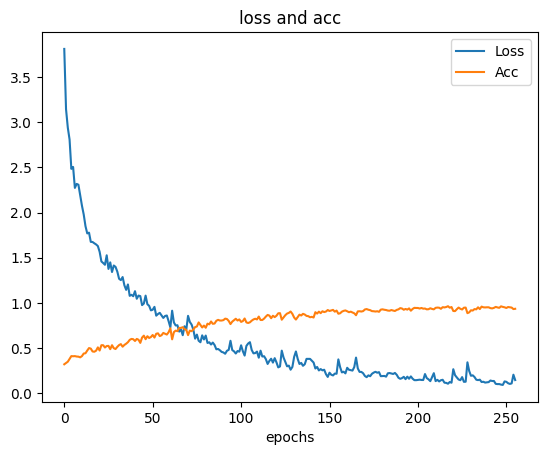

訓練時間為: 60.08 秒


In [33]:
model = Sequential()

# 第一層卷積層，filter=32, kernal size: 3x3, padding: same, activation: selu
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='selu', input_shape= (60,11,1)))
model.add(BatchNormalization())

# 第二層卷積層，filter=32, kernal size: 3x3, padding: same, activation: selu
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='selu'))
model.add(BatchNormalization())
# 第二層池化層，池化大小=2x2，取最大值
model.add(MaxPooling2D(pool_size=(2, 2)))
# 第二層 Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
model.add(Dropout(0.25))

# 第三層卷積層，filter=64, kernal size: 3x3, padding: same, activation: selu
model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='selu'))
model.add(BatchNormalization())
# 第三層池化層，池化大小=2x2，取最大值
model.add(MaxPooling2D(pool_size=(2, 2)))
# 第三層 Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.35
model.add(Dropout(0.25))

# 第四層卷積層，filter=128, kernal size: 3x3, padding: same, activation: selu
model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='selu'))
model.add(BatchNormalization())
# 第四層池化層，池化大小=2x2，取最大值
model.add(MaxPooling2D(pool_size=(2, 2)))
# 第四層 Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.45
model.add(Dropout(0.25))

# 將多維的輸入一維化
model.add(Flatten())

# 第一層全連接層，128個output, activation: selu
model.add(Dense(128, activation='selu'))

#Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.5
model.add(Dropout(0.5))

#全連接層，64個output, activation: selu
model.add(Dense(64, activation='selu'))

#Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.5
model.add(Dropout(0.5))

#全連接層，5個output, activation: softmax
model.add(Dense(4, activation='softmax'))
# 編譯: 選擇損失函數、優化方法及成效衡量方式
model.compile(loss='categorical_crossentropy'
                  ,optimizer='adam',metrics=["accuracy"])
model.summary()
start = time.time()
# 進行訓練, 訓練過程會存在 train_history 變數中
train=model.fit(X_train, y_train_hot, batch_size=60, epochs=125, verbose=2) #,

end = time.time()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], X_test.shape[2], 1)
#score = model.evaluate(X_test, y_test_hot, verbose=1)


'''儲存訓練過程中 的 loss and acc'''
loss = train.history['loss']
acc = train.history['accuracy']

'''圖形印出loss and acc '''
plt.title('loss and acc')
plt.plot(loss)
plt.plot(acc)
plt.legend(['Loss', 'Acc'])
plt.xlabel('epochs')
plt.show()

print("訓練時間為: {:.2f} 秒".format(end-start))
# 模型存檔
model.save("ASR.keras")  # creates a HDF5 file 'model.h5'





In [34]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    labels = sorted(classes, key=int)
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━

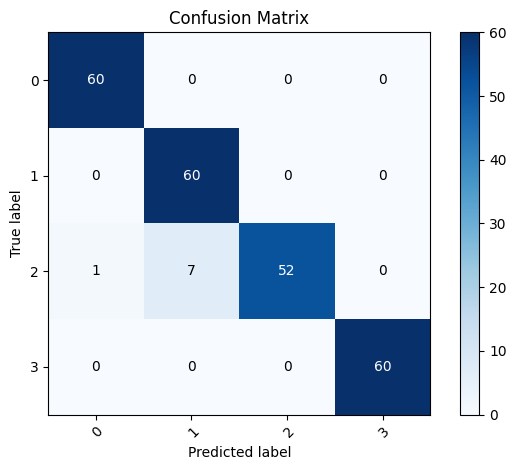

類別 0 的召回率(recall)為: 1.0
類別 1 的召回率(recall)為: 1.0
類別 2 的召回率(recall)為: 0.8666666666666667
類別 3 的召回率(recall)為: 1.0
Unweighted Average Recall(UAR): 0.9666666666666667
辨識正確率為: 96.66666666666667% (232/240)


In [35]:
from keras.models import load_model
import numpy as np
import librosa
import os
from keras.preprocessing import sequence
from sklearn.metrics import confusion_matrix, recall_score
import matplotlib.pyplot as plt
#from preprocess import *


path = '/content/drive/MyDrive/cough_sound_identification/cnntest/'

def predict(model):
    pred = []
    true = []
    ii = []
    jj = []
    labels = os.listdir(path)
    for i in labels:
        for j in os.listdir(path + i):
            ii.append(i)
            jj.append(j)
            true.append(int(i[i.find('(')+1]))

            mfcc = wav2mfcc(path + i + '/' + j)

            delta_mfccs = librosa.feature.delta(mfcc)
            delta2_mfccs = librosa.feature.delta(mfcc, order=2)

            # Concatenate MFCCs, delta MFCCs and delta2 MFCCs
            all_mfccs = np.concatenate([mfcc, delta_mfccs, delta2_mfccs], axis=0)

            mfcc_reshaped = all_mfccs.reshape(1, 60, 11, 1)
            tmp = model.predict(mfcc_reshaped)
            pred.append(np.argmax(tmp))
    #print(ii)
    #print()
    #print(jj)
    #print(true)
    #print()
    #print(pred)
    plot_confusion_matrix(true, pred, classes = labels,
                          title='Confusion Matrix')
    right = sum([1 for i, j in zip(true, pred) if i == j])
    acc_rate = right / len(true) * 100
    plt.savefig("Acc_"+str(acc_rate)+"_.png")
    plt.show()

    # 計算每個類別的召回率
    recall_scores = recall_score(true, pred, labels=[0,1,2,3], average=None)
    for i, recall in enumerate(recall_scores):
        print(f"類別 {i} 的召回率(recall)為: {recall}")

    # 計算UAR
    uar = np.mean(recall_scores)
    print(f"Unweighted Average Recall(UAR): {uar}")

    print('辨識正確率為: {acc}% ({t}/{p})'.format(acc=acc_rate, t=right, p=len(true)))


'''=======================以上完全不用改動==================='''

if __name__ == '__main__':
    '''
    如果要使用完整訓練的模型，請把下面兩行註解拿掉
       不用的時候請註解回去 使用自己訓練的模型
    '''
    model = load_model("ASR.keras")
    l = ["zero(0)","one(1)","two(2)","three(3)"]
    filepath = []
    for i in range(len(l)):
        path_ = path+l[i]+"/1_"+str(i)+".wav"
        filepath.append(path_)

    for i in filepath:
        #print(i)
        pass
        #print(predict(i, model=model))



    predict(model)
